### <p style="text-align: center;">Community Segmentation</p>
# <p style="text-align: center;">Credit Card Clustering</p>
#### <p style="text-align: center;">Jeffrey D Nelson and David N Campbell</p>

The purpose of this notebook is to use K-Means clustering to segment customers based on credit card usage. This segmentation will be used to determine the marketing strategy for each segment.

## Data Exploration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set seaborn defaults
sns.set()

df = pd.read_csv(r'data/CC_GENERAL.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [2]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


## Data Preprocessing

Before we can train any models, we must preprocess the data. First, we handle non-numeric features.

In this case, there is only one non-numeric feature, `CUST_ID`. This was found using `df.select_dtypes(exclude=np.number).columns`. This feature is irrelevant, so we just drop it.

In [3]:
df = df.drop(columns=['CUST_ID'])

Next, we handle features with missing values. The simplest approach is to replace missing values with the median for the data set.

In [4]:
df.isnull().sum().sort_values(ascending=False).head()

MINIMUM_PAYMENTS          313
CREDIT_LIMIT                1
BALANCE                     0
CASH_ADVANCE_FREQUENCY      0
PRC_FULL_PAYMENT            0
dtype: int64

In [5]:
# Handle missing values in MINIMUM_PAYMENTS
min_payments_missing = df['MINIMUM_PAYMENTS'].isnull() == True
min_payments_median = df['MINIMUM_PAYMENTS'].median()

df.loc[min_payments_missing, 'MINIMUM_PAYMENTS'] = min_payments_median

# Handle missing values in CREDIT_LIMIT
credit_limit_missing = df['CREDIT_LIMIT'].isnull() == True
credit_limit_median = df['CREDIT_LIMIT'].median()

df.loc[credit_limit_missing, 'CREDIT_LIMIT'] = credit_limit_median

In [6]:
df.isnull().sum().sort_values(ascending=False).head()

BALANCE                   0
CASH_ADVANCE_FREQUENCY    0
PRC_FULL_PAYMENT          0
MINIMUM_PAYMENTS          0
PAYMENTS                  0
dtype: int64

### Scaling

After a few iterations, we realized that our clustering was performing poorly due to outliers in the dataset which could not be resolved with StandardScaler alone. Therefore, we decided to log transform features that were highly skewed. As an example of skewness, we show BALANCE and CASH_ADVANCE.

Text(0.5, 1.0, 'Skewness of BALANCE')

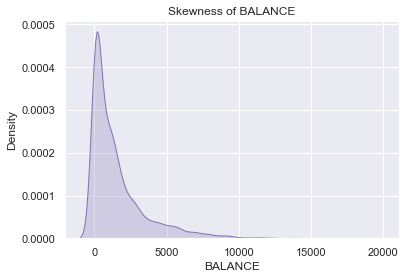

In [7]:
plt.clf()
ax = plt.gca()

g = sns.kdeplot(df['BALANCE'], color='m', shade=True, ax=ax)
g.set_title('Skewness of BALANCE')

Text(0.5, 1.0, 'Skewness of CASH_ADVANCE')

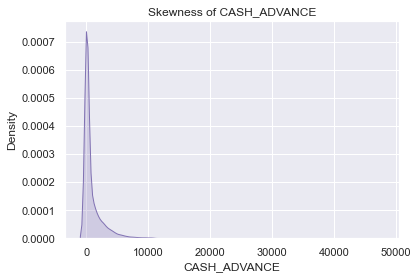

In [8]:
plt.clf()
ax = plt.gca()

g = sns.kdeplot(df['CASH_ADVANCE'], color='m', shade=True, ax=ax)
g.set_title('Skewness of CASH_ADVANCE')

In [9]:
from scipy.stats import skew

log_scale = []
standard_scale = []

for feature in df.columns:
    feature_skew = skew(df[feature])
    if feature_skew > np.abs(2):
        log_scale.append(feature)
    else:
        standard_scale.append(feature)
    print("Skew for %s: %f" % (feature, feature_skew))

Skew for BALANCE: 2.392985
Skew for BALANCE_FREQUENCY: -2.022926
Skew for PURCHASES: 8.142904
Skew for ONEOFF_PURCHASES: 10.043399
Skew for INSTALLMENTS_PURCHASES: 7.297897
Skew for CASH_ADVANCE: 5.165743
Skew for PURCHASES_FREQUENCY: 0.060154
Skew for ONEOFF_PURCHASES_FREQUENCY: 1.535355
Skew for PURCHASES_INSTALLMENTS_FREQUENCY: 0.509116
Skew for CASH_ADVANCE_FREQUENCY: 1.828380
Skew for CASH_ADVANCE_TRX: 5.720339
Skew for PURCHASES_TRX: 4.629879
Skew for CREDIT_LIMIT: 1.522381
Skew for PAYMENTS: 5.906630
Skew for MINIMUM_PAYMENTS: 13.850125
Skew for PRC_FULL_PAYMENT: 1.942494
Skew for TENURE: -2.942524


As you can see, some features are heavily right or left-skewed (high positive or negative value). For those features with a skew greater than 2, we will log transform them. The other features will be scaled normally.

In [10]:
X = df.copy()

for feature in log_scale:
    X[feature] = np.log1p(df[feature])
for feature in standard_scale:
    mean = df[feature].mean()
    std = df[feature].std()
    X[feature] = (df[feature] - mean) / std

In [11]:
X.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,3.735304,-0.249421,4.568506,0.000000,4.568506,0.000000,-0.806445,-0.678623,-0.707274,-0.675311,0.000000,1.098612,-0.960325,5.312231,4.945277,-0.525522,0.360659
1,8.071989,0.134317,0.000000,0.000000,0.000000,8.770896,-1.221690,-0.678623,-0.916944,0.573931,1.609438,0.000000,0.688640,8.319725,6.978531,0.234214,0.360659
2,7.822504,0.518055,6.651791,6.651791,0.000000,0.000000,1.269772,2.673302,-0.916944,-0.675311,0.000000,2.564949,0.826054,6.434654,6.442994,-0.525522,0.360659
3,7.419183,-1.016896,7.313220,7.313220,0.000000,5.331694,-1.014069,-0.399297,-0.916944,-0.258899,0.693147,0.693147,0.826054,0.000000,5.747301,-0.525522,0.360659
4,6.707735,0.518055,2.833213,2.833213,0.000000,0.000000,-1.014069,-0.399297,-0.916944,-0.675311,0.000000,0.693147,-0.905359,6.521114,5.504483,-0.525522,0.360659


### Feature Correlations

The correlation between features is an important relationship to explore, and a great way to visualize these correlations is using a heat map, which seaborn makes simple.

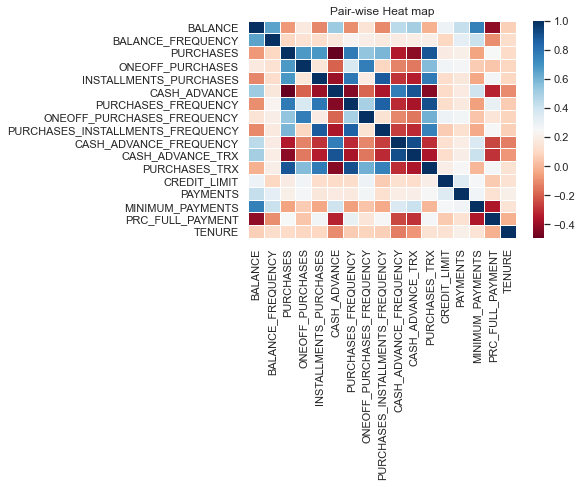

In [12]:
import seaborn as sns

g = sns.heatmap(X.corr(), annot=False, linewidths=0.1, vmax=1.0, linecolor='white', cmap=plt.cm.RdBu)
g.set_title("Pair-wise Heat map")
plt.show()

The more blue a block is, the more positively correlated two features are. The more red a block is, the more negatively correlated two features are.

From this graph, there are a few strong positive relationships, many of which are for features that we expected to be related, like BALANCE and BALANCE_FREQUENCY, PURCHASES and ONEOFF_PURCHASES, etc.

## PCA

Since there are so many features, we use PCA to decompose to the subset that captures the majority of the variance in the dataset.

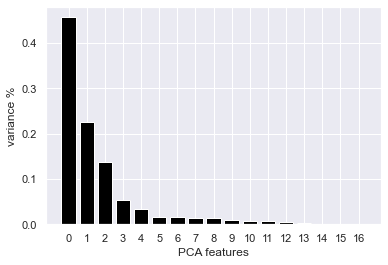

In [13]:
from sklearn.decomposition import PCA

num_features = len(df.columns)

pca = PCA(n_components=num_features)
principal_components = pca.fit_transform(X)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

To explain > 80% of the variance, it will take ~3 features. Let's see how much each original feature contributes to each PCA vector.

In [14]:
pca = PCA(n_components=3)
X_pca = pd.DataFrame(pca.fit_transform(X), index=df.index, columns=['PC-1', 'PC-2', 'PC-3'])
X_pca.head()

,PC-1,PC-2,PC-3
0,0.773831,-5.622229,0.522553
1,-9.049274,1.473689,1.063839
2,2.865258,1.691624,-5.194908
3,-0.645690,2.667323,-4.864974
4,-1.472379,-2.718000,-3.733228


In [15]:
pc_df = pd.DataFrame(pca.components_.T, columns=['PC-1', 'PC-2', 'PC-3'], index=df.columns)
pc_df

,PC-1,PC-2,PC-3
BALANCE,-0.099492,0.402800,0.124908
BALANCE_FREQUENCY,0.004778,0.119405,0.078493
PURCHASES,0.511594,0.216481,0.040013
ONEOFF_PURCHASES,0.370082,0.556325,-0.531052
INSTALLMENTS_PURCHASES,0.439706,-0.009566,0.690037
CASH_ADVANCE,-0.508885,0.545373,0.310819
PURCHASES_FREQUENCY,0.153421,0.030967,0.124674
ONEOFF_PURCHASES_FREQUENCY,0.100148,0.136302,-0.108370
PURCHASES_INSTALLMENTS_FREQUENCY,0.126121,-0.011283,0.215528
CASH_ADVANCE_FREQUENCY,-0.108394,0.136560,0.076268


We can see that the first principal component is heavily affected by PURCHASES, ONEOFF_PURCHASES, and INSTALLMENT_PURCHASES. The second principal component is heavily affected by BALANCE, ONEOFF_PURCHASES, and CASH_ADVANCE.

## K-Means

Now, we run K-Means on these PCA components. First, we determine the optimal number of clusters.

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
clusters = [ i for i in range(2, 12) ]

for i in clusters:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_pca)
    score = silhouette_score(X_pca, kmeans.predict(X_pca))
    print("Silhouette score for {num} clusters: {score}".format(num=i, score=score))
    silhouette_scores.append(score)

Silhouette score for 2 clusters: 0.4194944456058029
Silhouette score for 3 clusters: 0.40843223253574645
Silhouette score for 4 clusters: 0.47037443974127857
Silhouette score for 5 clusters: 0.5109874561979829
Silhouette score for 6 clusters: 0.5324483291392724
Silhouette score for 7 clusters: 0.5525270193512384
Silhouette score for 8 clusters: 0.5027103212081327
Silhouette score for 9 clusters: 0.46331134460182716
Silhouette score for 10 clusters: 0.4342998560026875
Silhouette score for 11 clusters: 0.42695102589835604


## Analysis

Seven clusters is optimal, but marketing to seven different groups can be logistically challenging for any company. We assume that our marketing department can only handle five different groups, and since the silhouette score is still high, going with 5 is a good choice for this dataset.

In [17]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_pca)

KMeans(n_clusters=5)

Let's print the cluster centers and the number of individuals in each cluster.

In [18]:
# Inverse transform
inverse_array = pd.DataFrame(pca.inverse_transform(kmeans.cluster_centers_), columns=df.columns)
for feature in log_scale:
    inverse_array[feature] = np.expm1(inverse_array[feature])
for feature in standard_scale:
    inverse_array[feature] = (df[feature].std() * inverse_array[feature]) + df[feature].mean()
inverse_array

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,4180.870542,1.043177,352.872483,143.361245,69.663244,728.353741,0.611367,0.341004,0.462103,0.297603,4.645879,11.106298,6482.425320,2654.914616,1018.147782,0.068780,11.645304
1,859.109619,0.855812,1.230348,0.047132,-0.064725,1155.158492,0.004274,-0.050361,-0.023675,0.292468,4.714895,0.056720,3646.045098,516.637935,493.801072,0.012025,11.239462
2,73.197946,0.788007,193.242754,0.565957,381.903020,0.175559,0.692559,0.021717,0.690669,-0.014132,-0.028528,8.430427,2995.142201,358.682384,180.399298,0.296116,11.509770
3,381.519677,0.911665,4548.592102,578.103223,393.694747,0.794709,0.886513,0.449620,0.657988,0.022690,0.162730,30.641652,5478.550235,1185.050791,324.728676,0.255163,11.762026
4,178.134927,0.772286,226.230459,512.116233,0.774618,0.973194,0.330886,0.396119,0.013755,0.010612,0.108571,4.203392,4162.535776,416.754847,191.667910,0.167169,11.507666


In [19]:
predictions = kmeans.predict(X_pca)

for i in range(5):
    print("Individuals in cluster %d: %d" % (i, np.count_nonzero(predictions == i)))

Individuals in cluster 0: 1819
Individuals in cluster 1: 2204
Individuals in cluster 2: 1969
Individuals in cluster 3: 1665
Individuals in cluster 4: 1293


## Marketing Analysis

From the above centers, we can derive the following clusters:

0. Those with high balance that make the median level of purchases.
1. Those with median balance that make almost no purchases and give a lot of cash in advance.
3. Those with an extremely low balance that make few purchases and have a low credit limit.
4. Those with a low balance that make an extremely high number of purchases.
5. Those with a quite low balance that make less than average purchases, but a lot of one-off purchases.

As such, our marketing department should focus on the individuals in cluster 0 and 4. Those in cluster 1 also deserve some attention, and they represent the largest group.